**Mount Drive**

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


**All imports**

In [1]:
import pandas as pd
import numpy as np
import math
import datetime as dt
import os

!pip install missingno
import missingno as msno

!pip install category_encoders
import category_encoders as ce
from sklearn import preprocessing

#library to decode ip addresses
!pip3 install ipwhois
from ipwhois import IPWhois

#library to get text similarity
!pip install jellyfish
import jellyfish

#library to get country name from phone numbers
# !pip install phonenumbers
# import phonenumbers
# from phonenumbers import geocoder

#get country code from country name
!pip install pycountry
import pycountry
countries = {}
for country in pycountry.countries:
    countries[country.name] = country.alpha_2
    
#get distance between lat long
!pip install mpu
import mpu    

import time
from datetime import date

pd.options.display.float_format = "{:.2f}".format

pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000
pd.set_option('display.max_colwidth', -1)  # or 199
np.set_printoptions(threshold=np.nan)

In [0]:
os.chdir('gdrive/My Drive/Colab Notebooks/Fraud_model')

In [0]:
#UDF
def target_fill(col):
  if pd.isnull(col):
    return 0
  return 1

def ip_country(col):
  try:
    match = IPWhois(col).lookup_whois()  
    match=match["nets"][0]['country']
  except:
      match=""
  return match

def attempNo(col):
  return col[-1]

def days_to_departure(row):
  return abs(pd.to_datetime(row.DepartureDate)-pd.to_datetime(row.timestamp)).days

def vacation_length(row):
  return abs(pd.to_datetime(row.DepartureDate)-pd.to_datetime(row.EndDate)).days

def country_ip_flight_MatchScore(row):
  booker=countries.get(row['BookerCountry_Name'])
  origin=countries.get(row['OriginCountryName'])
  dest=countries.get(row['DestinationCountryName'])
#   ip=row['ip_country']
  score =0
#   if (booker==ip and ip==origin) or (booker==ip and ip==dest):
  if (booker==origin) or (booker==dest):
    score+=1
  return score

def oneWayDistance(row):
  if row['OneWayOrReturn']=="One Way":
    try:
      dist = mpu.haversine_distance((row['OriginLatitude'],row['OriginLongitude']), (row['DestinationLatitude'],row['DestinationLongitude']))
    except:
      dist=-9999
  else:
    dist=9999
  return dist

def cities_in_itinerary(col):
  return len(col.split("-")) 

def email_real_check(row):
  l=len(row['customer_name'].split(' '))
  
  score=0
  score=jellyfish.jaro_distance(row['email_id'].lower(), row['customer_name'].lower())
  try:
    if row['dob_month'] in row['customer_name']:
      score+=0.5
    if row['dob_year'] in row['customer_name']:
      score+=0.5
    if row['dob_day'] in row['customer_name']:
      score+=0.5  
    if row['customer_name'].split(' ')[0] in row['email_id']:
      score+=0.7
    if row['customer_name'].split(' ')[l-1] in row['email_id']:
      score+=0.7   
  except: pass    
  return score
  
def cabinclass(col):
  if col.split('|')[0].startswith('Economy'):
    clas='Economy'
  elif col.split('|')[0].startswith('PremiumEconomy'):
    clas='PremiumEconomy'
  elif col.split('|')[0].startswith('Business'):
    clas='Business'
  elif col.split('|')[0].startswith('First'):
    clas='First'    
  else:
    clas='Unknown'
  return clas

now = dt.datetime.now()

def get_age(col):
  return now.year-pd.to_datetime(col).year  

def bookerIsTravelAgency(col):
  if ('travel') in col.lower():
    return True
  else:
    return False  
  
def booking_daytime(col):
  if col>11 and col<=5:
    return '4'
  elif col>5 and col<=9:
    return '3'
  elif col>9 and col<=17:
    return '2'
  else:
    return 1  

def bookgerAgeBracket(col):
  if col>=18 and col<=25:
    return 1
  elif col>25 and col<=40:
    return 2
  elif col>40 and col<=60:
    return 3
  elif col>60:
    return 4
  else:
    return 5

In [3]:
#BigQuery connection
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

from google.cloud import bigquery
client = bigquery.Client(project='travix-bi')

Authenticated


In [0]:
#Payment authroized filter will be removed when deploying before pre auth
code='''create table analyst.gj_model_base as
select distinct post.metaData.UtcTimeStamp as timestamp
,post.payload.payload.ReferencePrefix as order_number
,post.payload.payload.PaymentInfo.PaymentReferenceId as pay_id
,fact.AffiliateCode as affiliate
,c.metaData.TrafficSource.ChannelCode as channelcode
,post.payload.payload.PaymentInfo.Amount as local_trans_amt
,post.payload.payload.PaymentInfo.Currency as trans_currency
,post.payload.payload.PaymentInfo.IsAuthorization as nonmor
,post.payload.payload.PaymentInfo.PaymentMethod as payment_method
,post.payload.payload.CardInfo.Eci as eci
,post.payload.payload.CardInfo.CvvMatch as card_cvvmatch
,post.payload.payload.CardInfo.AvsMatch as card_avsmatch
,post.payload.payload.CardInfo.CreditCardBin as card_bin
,post.payload.payload.CardInfo.CreditCardCountry as card_country
,post.payload.payload.CustomerInfo.IpAddress as ip_address
,post.payload.payload.CustomerInfo.Email as customer_email
,post.payload.payload.CustomerInfo.FullName  as customer_name
,post.payload.payload.CustomerInfo.Title as customer_title
,post.payload.payload.PaymentInvoiceId as success_attempt_id
,post.payload.payload.CardInfo.MaskedCardNumber as card_num
,fact.LanguageCode as website_language
,fact.BrandRegion as brand_continent
,fact.BrandTimeZone 
,fact.HasTicketInsurance
,fact.HasInsurance
,fact.HasBaggage
,fact.HasBaggage_Sale
,fact.HasAirhelpPlus
,fact.UsedVoucher
,fact.HasSP
,fact.GA_DeviceCategory
,fact.GA_DeviceIsMobile
,fact.BookerContactPhone
,fact.BookerGender as gender
,fact.BookerDateOfBirth as dob
,fact.BookerStreet
,fact.BookerZipCode
,fact.BookerCity
,fact.BookerCountry_Name
,fact.BookerState
from event_streams_payment.payment_invoice_created c
left join ( SELECT
          pre_fraud_indicator,
          pre_auth_date,
          concat(order_number,"_FlightBookingOrder_",cast(inv as string)) as invoice_id
        FROM (
          SELECT
            rank() over(partition by payload.payload.ReferencePrefix order by metaData.UtcTimeStamp) as inv,
            pre_auth.payload.payload.ReferencePrefix order_number,
            pre_auth.UtcTimeStamp pre_auth_date,
            pre_auth.payload.payload.FraudInfo.FraudIndicator pre_fraud_indicator,
            ROW_NUMBER() OVER (PARTITION BY pre_auth.payload.payload.PaymentInvoiceId ORDER BY pre_auth.UtcTimeStamp DESC) rn
          FROM
            event_streams_payment.payment_pre_auth_fraud_check pre_auth)) b
on c.payload.payload.PaymentInvoiceId=b.invoice_id
left join event_streams_payment.payment_post_auth_fraud_check post
      on c.payload.payload.PaymentInvoiceId=post.payload.payload.PaymentInvoiceId
left join  event_streams_payment.payment_fraud_check_resolution r
      on c.payload.payload.PaymentInvoiceId=r.payload.payload.PaymentInvoiceId
left join fact.order fact
      on c.payload.payload.ReferencePrefix=fact.OrderNumber
where (post.payload.payload.FraudInfo.FraudIndicator = 'Green') OR (post.payload.payload.FraudInfo.FraudIndicator = 'Yellow' AND r.payload.payload.FraudInfo.FraudIndicator='Green')
and post.payload.payload.PaymentInfo.Status='Authorized' and cast(date(post.metaData.UtcTimeStamp) as date) between '2018-05-01' and '2018-11-18'
''' 

client.query(code).to_dataframe()

code='''create table analyst.gj_model_raw as
select distinct c.*
,info.TotalAmountEUR
,info.FareCarrierName as airline
,info.Consolidator
,info.OriginAirportCode
,info.OriginCityName
,info.OriginCountryName
,info.OriginWorldPartName
,info.OriginRegion
,info.OriginSubRegion
,info.OriginLatitude
,info.OriginLongitude
,info.DestinationAirportCode
,info.DestinationCityName
,info.DestinationCountryName
,info.DestinationWorldPartName
,info.DestinationRegion
,info.DestinationSubRegion
,info.DestinationLatitude
,info.DestinationLongitude
,info.DepartureDate
,info.ReturnDate
,info.EndDate
,info.Supplier
,info.DomesticOrInternational
,info.Haul
,info.OneWayOrReturn
,info.IsCombinedOneWay
,info.FareType
,info.IsITFare
,info.GdsOfficeId
,info.Itinerary
,info.TotalNumberOfPassengers
,info.TotalNumberOfAdults
,info.TotalNumberOfChildren
,info.TotalNumberOfInfants
,info.COW_NumberOfSegments
,info.COW_NumberOfInboundSegments
,info.COW_NumberOfOutboundSegments
,info.NumberOfTickets
,info.FareBaseAmount
,info.BookingClasses
,info.CabinClasses
,info.TicketingMethod
,info.HasSplitPnr
,info.DeviceType
,info.OrderDateBrandTime_Year
,info.OrderDateBrandTime_Month
,info.OrderDateBrandTime_DayOfWeek
,info.OrderDateBrandTime_Hour
,info.IsLowCost
from `analyst.gj_model_base` c
left join fact.order_information info
      on c.order_number=info.OrderNumber''' 


client.query(code).to_dataframe()

# There are a lot of nulls. Let us remove them

code='''
create table analyst.fraud_model_base_data as
select * 
from analyst.gj_model_raw
where BookingClasses is not null
''' 

client.query(code).to_dataframe()

In [6]:
%%time

#Data is unique at pay id level but not at order level. Let us dedupe at order level
code='''
select * 
from analyst.fraud_model_base_data
limit 20000
''' 

df=client.query(code).to_dataframe()
df.drop_duplicates(subset='order_number', keep='first', inplace=True)

CPU times: user 6 s, sys: 354 ms, total: 6.35 s
Wall time: 20.6 s


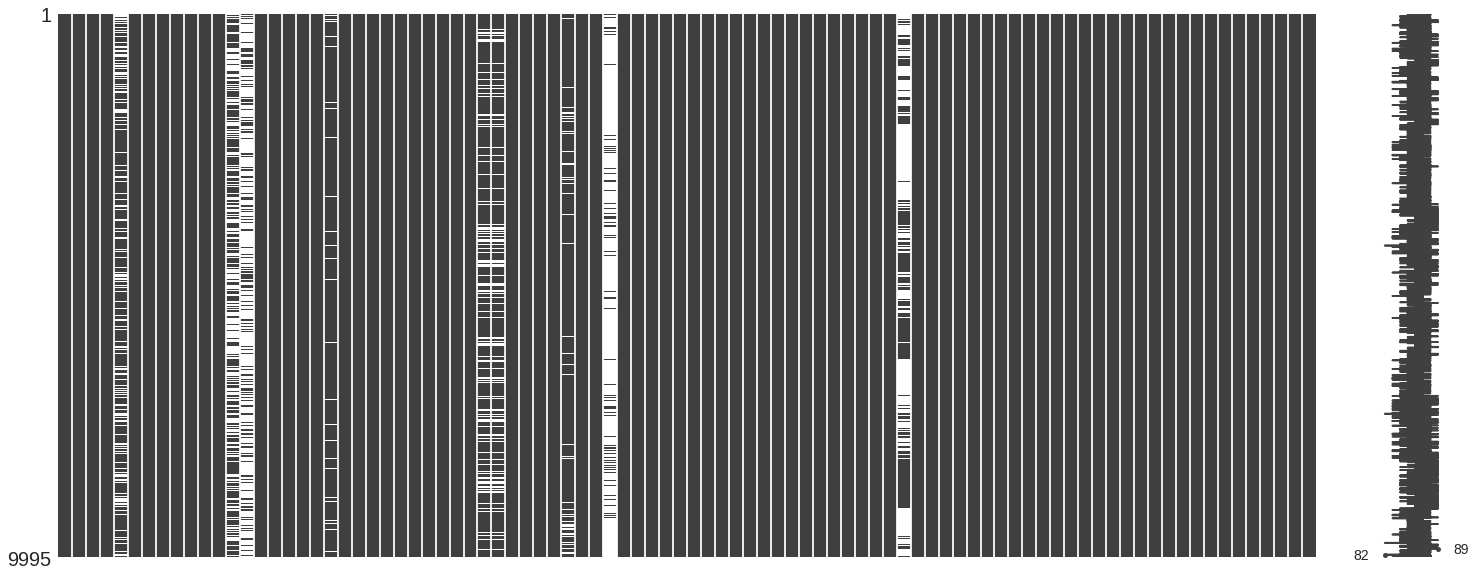

In [0]:
msno.matrix(df)

## Adding target variable

In [7]:
tar1=pd.read_csv('gdrive/Team Drives/Data_science_reports/Fraud_model/mor_cbk.csv', delimiter=";")
tar2=pd.read_csv('gdrive/Team Drives/Data_science_reports/Fraud_model/nonmor_cbk.csv', delimiter=";")

df=df.merge(tar1, how='left', left_on='pay_id', right_on='PayId')
df.drop(['PayId'], axis=1, inplace=True)

df=df.merge(tar2, how='left', left_on='order_number', right_on='OrderNumber')
df.drop(['OrderNumber'], axis=1, inplace=True)

#Target variable: 1 = Fraud

df['target1']=df['CBK_file_x'].apply(lambda x: target_fill(x))
df.drop(['CBK_file_x'], axis=1, inplace=True)


df['target2']=df['CBK_file_y'].apply(lambda x: target_fill(x))
df.drop(['CBK_file_y'], axis=1, inplace=True)

df['target']=df['target1']+df['target2']

df.drop(['target1','target2'], axis=1, inplace=True)

df.target.value_counts()

0    19976
1    13   
Name: target, dtype: int64

In [0]:
# df['ip_address']=df['ip_address'].str.encode('utf-8')

# import re
# def phoneno_toCountry(col):
#   result=""
#   try:
#     if(len(col)-len(col.replace(" ",""))>0) and col.startswith("+"):
#       query = phonenumbers.parse(col, None)
#       result=repr(geocoder.description_for_number(query, "en"))
#   except:
#     result="Unknown"
#   return result

# df['BookerPhoneCountry']=df.BookerContactPhone.apply(lambda x: phoneno_toCountry(x))

##Feature engineering

In [10]:
%%timeit

# IP related
# df['ip_country']= df['ip_address'].apply(lambda x: ip_country(x))

email=df['customer_email'].str.split("@",expand=True)
email.columns=['id','domain']

df['email_id']=email['id']
df['email_user_id_len']=email['id'].apply(lambda x: len(x))
df['email_domain']=email['domain']

#DOB splits
dob=df['dob'].astype('str').str.split(" ",expand=True)
dob.columns=['use','drop']
dob=dob['use'].str.split("-",expand=True)
dob.columns=['year','month','day']
df['dob_year']=dob['year']
df['dob_month']=dob['month']
df['dob_day']=dob['day']

df['email_sanity_score']=df.apply(email_real_check,axis=1)

#Others
df['bookerIsTravelAgency'] = df.customer_name.apply(lambda x: bookerIsTravelAgency(x))

df['successful_attempt_no']=df.success_attempt_id.apply(lambda x: attempNo(x))

df['country_ip_flight_MatchScore']=df.apply(country_ip_flight_MatchScore,axis=1)

df['flight_distance']=df.apply(oneWayDistance,axis=1)

df['days_to_departure']=df.apply(days_to_departure,axis=1)
df['vacation_length']=df.apply(vacation_length,axis=1)

df['cities_in_itinerary']=df.Itinerary.apply(lambda x: cities_in_itinerary(x))

df['cabin_class']=df.CabinClasses.apply(lambda x: cabinclass(x))

df['bookerAge']=df.dob_year.apply(lambda x: get_age(x))

df['name_len']=df.customer_name.apply(lambda x: len(x))

## Time related variables to be binned
df['weekend_booking']=df.OrderDateBrandTime_DayOfWeek.apply(lambda x: 1 if x in (1,7) else 0)
                                                            
df['booking_daytime']= df.OrderDateBrandTime_Hour.apply(lambda x: booking_daytime(x))    
                                                            
df['bookerAgeBracket']=df.bookerAge.apply(lambda x: bookgerAgeBracket(x))

1 loop, best of 3: 17.5 s per loop


## Drop extra variables

In [11]:
cols_to_drop=['BookerContactPhone','success_attempt_id','email_id','customer_email','dob','card_num','card_country','BookerStreet','BookerZipCode','BookerState','card_bin','customer_name','OriginLatitude','OriginLongitude','DestinationLatitude','DestinationLongitude',
             'DepartureDate','ReturnDate','EndDate','FareType','GdsOfficeId','Itinerary','BookingClasses','CabinClasses','TicketingMethod','GA_DeviceIsMobile','GA_DeviceCategory','OrderDateBrandTime_Year',
             'ip_address','dob_day','dob_year','OrderDateBrandTime_DayOfWeek','OrderDateBrandTime_Hour','bookerAge','BrandTimeZone']

df.drop(cols_to_drop,axis=1,inplace=True)
df.head()

,timestamp,order_number,pay_id,affiliate,channelcode,local_trans_amt,trans_currency,nonmor,payment_method,eci,card_cvvmatch,card_avsmatch,customer_title,website_language,brand_continent,HasTicketInsurance,HasInsurance,HasBaggage,HasBaggage_Sale,HasAirhelpPlus,UsedVoucher,HasSP,gender,BookerCity,BookerCountry_Name,TotalAmountEUR,airline,Consolidator,OriginAirportCode,OriginCityName,OriginCountryName,OriginWorldPartName,OriginRegion,OriginSubRegion,DestinationAirportCode,DestinationCityName,DestinationCountryName,DestinationWorldPartName,DestinationRegion,DestinationSubRegion,Supplier,DomesticOrInternational,Haul,OneWayOrReturn,IsCombinedOneWay,IsITFare,TotalNumberOfPassengers,TotalNumberOfAdults,TotalNumberOfChildren,TotalNumberOfInfants,COW_NumberOfSegments,COW_NumberOfInboundSegments,COW_NumberOfOutboundSegments,NumberOfTickets,FareBaseAmount,HasSplitPnr,DeviceType,OrderDateBrandTime_Month,IsLowCost,target,email_user_id_len,email_domain,dob_month,email_sanity_score,bookerIsTravelAgency,successful_attempt_no,country_ip_flight_MatchScore,flight_distance,days_to_departure,vacation_length,cities_in_itinerary,cabin_class,name_len,weekend_booking,booking_daytime,bookerAgeBracket
0,2018-11-27 13:59:33+00:00,KUSW-5572385,000000000070861919B5,KAYAKUSWL,kayakuswlmob,3132.52,USD,False,MC,02,P,U,Mr.,EN,Americas,False,False,False,False,False,False,False,M,SILVER SPRING,USA,2760.94,EGYPTAIR,TXNL,NDJ,N'Djamena,Chad,Africa,Africa,Middle Africa,CAI,Cairo,Egypt,Middle East,Africa,Northern Africa,Worldspan,International,Long Haul,Return,False,False,6,2,4,0,2,1,1,6,3132.52,False,Desktop,11,False,0,15,gmail.com,07,0.79,False,1,0,9999.00,29,9,3,Economy,15,0,1,2
1,2019-01-15 13:12:15+00:00,VUS-9710716,0000000000EB08AAA924,VAYAMAUS,None,1257.96,USD,False,MC,01,P,U,Mr.,EN,Americas,False,False,False,False,False,False,False,M,ABILENE,USA,1096.89,EGYPTAIR,TXNL,NDJ,N'Djamena,Chad,Africa,Africa,Middle Africa,CAI,Cairo,Egypt,Middle East,Africa,Northern Africa,Amadeus,International,Long Haul,Return,False,False,3,2,0,1,2,1,1,3,1232.96,False,Mobile,1,False,0,7,gmail.com,04,0.59,False,2,0,9999.00,29,23,3,Economy,20,0,1,2
2,2018-12-26 16:38:33+00:00,KUSW-5823802,0000000000508A6809E1,KAYAKUSWL,kayakuswld,800.55,USD,False,VISA,06,P,U,Mr.,EN,Americas,False,False,False,False,False,False,False,M,BRAMPTON,Canada,702.16,EGYPTAIR,TXUS,NDJ,N'Djamena,Chad,Africa,Africa,Middle Africa,YYZ,Toronto,Canada,North America,Americas,Northern America,Amadeus,International,Long Haul,One Way,False,False,1,1,0,0,2,0,2,1,800.55,False,Desktop,12,False,0,9,live.ca,01,0.69,False,1,1,9448.37,80,0,3,Economy,18,0,3,2
3,2018-07-17 14:17:01+00:00,BFR-8107127,4158840421,BUDGETAIRFR,,1081.41,EUR,False,AMEX,05,M,U,M.,FR,Europe,False,False,False,False,False,True,True,M,TOURS,France,1081.41,ROYAL AIR MAROC,TXNL,NDJ,N'Djamena,Chad,Africa,Africa,Middle Africa,ORY,Paris,France,Europe,Europe,Western Europe,Worldspan,International,Long Haul,One Way,False,False,3,1,2,0,2,0,2,3,1096.37,False,Mobile,7,False,0,10,yahoo.fr,06,0.55,False,1,1,4233.90,15,0,3,Economy,16,0,2,2
4,2019-01-03 18:01:35+00:00,BUK-12066397,0000000000A56A28FBB5,BUDGETAIRUK,skyscanneruk,598,GBP,False,MASTERDC,02,P,U,Mr.,EN,Europe,False,False,False,False,False,False,False,M,NDJAMENA,Chad,664.14,ETHIOPIAN AIRLINES,TXNL,NDJ,N'Djamena,Chad,Africa,Africa,Middle Africa,DLA,Douala,Cameroon,Africa,Africa,Middle Africa,Amadeus,International,Short Haul,Return,False,False,2,2,0,0,2,1,1,2,610.00,False,Desktop,1,False,0,14,free.fr,05,0.95,False,1,1,9999.00,14,5,3,Economy,14,0,2,3


## Missing data

In [12]:
# The missing channel code means that it was a direct booking. So it has a meaning
df.isnull().sum()

timestamp                       0   
order_number                    0   
pay_id                          0   
affiliate                       0   
channelcode                     5275
local_trans_amt                 0   
trans_currency                  0   
nonmor                          0   
payment_method                  0   
eci                             0   
card_cvvmatch                   0   
card_avsmatch                   0   
customer_title                  0   
website_language                0   
brand_continent                 0   
HasTicketInsurance              0   
HasInsurance                    0   
HasBaggage                      0   
HasBaggage_Sale                 0   
HasAirhelpPlus                  0   
UsedVoucher                     0   
HasSP                           0   
gender                          0   
BookerCity                      2   
BookerCountry_Name              2   
TotalAmountEUR                  0   
airline                         19  
C

##Categorical variables encoding


*   Binning
*   Boolean variables > 1,0
*   Leave one out
*   Label encoding



In [0]:
all_cat_cols=['affiliate','channelcode','trans_currency','nonmor','payment_method','eci','card_cvvmatch','card_avsmatch','customer_title','website_language',
          'brand_continent','HasTicketInsurance','HasInsurance','HasBaggage','HasBaggage_Sale','HasAirhelpPlus','UsedVoucher','HasSP','gender',
          'BookerCity','BookerCountry_Name','airline','Consolidator','OriginAirportCode','OriginCityName','OriginCountryName','OriginWorldPartName','OriginRegion',
          'OriginSubRegion','DestinationAirportCode','DestinationCityName','DestinationCountryName','DestinationWorldPartName','DestinationRegion','DestinationSubRegion',
          'Supplier','DomesticOrInternational','Haul','OneWayOrReturn','IsCombinedOneWay','IsITFare',
          'HasSplitPnr','DeviceType','IsLowCost','email_domain','cabin_class','bookerIsTravelAgency','weekend_booking','OrderDateBrandTime_Month','dob_month','booking_daytime',
         'bookerAgeBracket']

already_binned=['weekend_booking','OrderDateBrandTime_Month','dob_month','booking_daytime','bookerAgeBracket']

# Boolean to Int
boolean_cols=list(df.select_dtypes(include=bool).columns)
df[boolean_cols]=df[boolean_cols].astype(int)
      

   
# loo_encoder = ce.LeaveOneOutEncoder(cols=[...])


# encoder.fit(X, y)
# X_cleaned = encoder.transform(X_dirty)

#-----------------------------------------------------------------

# lab_encoder = preprocessing.LabelEncoder()
# X_cleaned1=le.fit_transform(cols=[...])

###Label encoding

The encoding has to be done on full training set. NOT IN BATCHES BECAUSE WE DO NOT WANT TO MISS LEVELS OF CATEGORICAL FEATURES

In [0]:
#Which columns to encode
label_col_list=[]
for col in all_cat_cols:  
  if col not in already_binned and col not in boolean_cols:    
    if df[col].nunique()<10:       
      label_col_list.append(col)
      
#Encoding
label_en_dict={col: {cat: n for n, cat in enumerate(df[col].astype('category').cat.categories)} 
               for col in label_col_list}

label_en_dict_reverse={col: {n: cat for n, cat in enumerate(df[col].astype('category').cat.categories)} 
               for col in label_col_list}

df.replace(label_en_dict,inplace=True)

### Leave one out encoding

In [0]:
#Which columns to encode
loo_en_cols=[]
for col in all_cat_cols:
  if col not in already_binned and col not in boolean_cols and col not in label_col_list:
    loo_en_cols.append(col)  


In [0]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import LabelBinarizer
from collections import defaultdict


class TypeSelector(BaseEstimator, TransformerMixin):
    def __init__(self, dtype):
        self.dtype = dtype

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        return X.select_dtypes(include=[self.dtype])


class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        if self.columns:
            return X[self.columns]
        return X


class LabelBinarizerPipelineFriendly(LabelBinarizer):
    def fit(self, X, y=None):
        """this would allow us to fit the model based on the X input."""
        super(LabelBinarizerPipelineFriendly, self).fit(X)

    def transform(self, X, y=None):
        return super(LabelBinarizerPipelineFriendly, self).transform(X)

    def fit_transform(self, X, y=None):
        return super(LabelBinarizerPipelineFriendly, self).fit(X).transform(X)


class ImputeMissingConstant(BaseEstimator, TransformerMixin):
    def __init__(self, constant):
        self.constant = constant

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        return X.fillna(self.constant)


class TransformToCategory(BaseEstimator, TransformerMixin):
    def __init__(self):
        return None

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        return X.astype("category")


class TransformToFloat(BaseEstimator, TransformerMixin):
    def __init__(self):
        return None

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        return X.astype("float64")


class DropGroupingKey(BaseEstimator, TransformerMixin):
    def __init__(self):
        return None

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        return X.drop('grouping_key', axis=1)


class EncoderMixin:
    def __init__(self, cols=None):
        self.cols = cols
        self.mapping_ = {}
        self.dim_ = None

    def fit(self, X, y=None, **kwargs):
        self.dim_ = X.shape[1]

        if self.cols is None:
            self.cols = self.get_categorical_cols(X)

    def transform(self, X):
        if self.dim_ is None:
            raise ValueError("Called transform before fit")

        if X.shape[1] != self.dim_:
            raise ValueError(
                f"Unexpected input dimension {X.shape[1]}, expected {self.dim_}"
            )

        if not self.cols:
            return X

    @staticmethod
    def get_categorical_cols(df):
        """Returns names of categorical columns in the DataFrame"""
        categorical_dtypes = ["object", "category"]
        return [
            col
            for col, dtype in zip(df.columns, df.dtypes)
            if dtype.name in categorical_dtypes
        ]


class MappingEncoder(EncoderMixin, BaseEstimator, TransformerMixin):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.mapping_ = {}

    def fit(self, X, y=None, **kwargs):
        super().fit(X, y, **kwargs)

        self.mapping_ = {col: self.col_map(X, y, col) for col in self.cols}

        return self

    def transform(self, X):
        super().transform(X)
        """
        Don't be tempted to put this in a dict comprehension
        When defining a function inside a loop that uses the loop variable in its body (e.g. col),
        the loop function's closure is bound to the variable, not its value.
        So all of the functions use the latest value assigned to the variable for computation.
        """
        X = X.copy()
        for col in self.cols:
            X[col] = X[col].map(self.mapping_[col])
            X[col] = X[col].fillna(self.impute_val_)

        return X

    def col_map(self, X, y, col):
        raise NotImplementedError(
            "subclasses of MappingEncoder should implement col_map"
        )

    @property
    def inv_mapping_(self):
        return {
            key: {val: key}
            for col, mapping in self.mapping_.items()
            for key, val in mapping.items()
        }


class MeanEncoder(MappingEncoder):
    """Encodes a categorical value as the category overall mean"""

    def col_map(self, X, y, col):
        return (
            pd.concat([X, y], axis=1)
            .groupby(col)
            .agg({y.name: "mean"})
            .to_dict()[y.name]
        )

    def fit(self, X, y, **kwargs):
        super().fit(X, y, **kwargs)
        assert isinstance(y, pd.Series), "Provide y as a Series object"
        self.impute_val_ = y.mean()
        return self


class OrdinalEncoder(MappingEncoder):
    """Encodes a categorical value ordinally"""

    def col_map(self, X, y, col):
        return defaultdict(
            int, {value: index + 1 for index, value in enumerate(pd.unique(X[col]))}
        )

    @property
    def impute_val_(self):
        return -1


class LOOEncoder(MappingEncoder):
    def __init__(self, sigma=0.05, **kwargs):
        super().__init__(**kwargs)
        self.sigma = sigma  # Sigma of the randomly distributed noise

    def col_map(self, X, y, col):
        """Calculate the category mean per column"""
        return (
            pd.concat([X, y], axis=1)
            .groupby(col)
            .agg({y.name: "mean"})
            .to_dict()[y.name]
        )

    def fit(self, X, y, **kwargs):
        super().fit(X, y, **kwargs)
        self.impute_val_ = y.mean()
        return self

    def transform(self, X, y=None):

        if y is None:
            # Transforming test set, simple mean encoding
            return super().transform(X)

        # Transforming the train set
        cat_counts = {col: X.groupby(col).size().to_dict() for col in self.cols}
        X_new = super().transform(X)

        for col in self.cols:
            cat_count = X[col].map(cat_counts[col])
            # remove each rows part in the mean calculation and add some noise
            X_new[col] = pd.Series(((X_new[col] * cat_count) - y) / (cat_count - 1))
            X_new[col] = X_new[col].fillna(self.impute_val_) + (
                np.random.randn(X.shape[0]) * self.sigma
            )

        return X_new

    
    
class LeaveOneOutEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, with_stdevs=True):
        self.with_stdevs = with_stdevs
        self.means = {}
        self.stdevs = {}
        self.columns_out = []

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        df = X.copy()
        for col in self.means.keys():
            mean_col_name = "{:s}_MEAN".format(col)

            if df[col].isnull().sum() > 0:
                if df[col].dtype.name == 'category':
                    df[col] = df[col].cat.add_categories(['unknown'])
                df[col].fillna("unknown", inplace=True)

            df[mean_col_name] = df.merge(
                pd.DataFrame(self.means[col]),
                how="left",
                left_on=[col],
                right_index=True,
            )["y"]
            if self.with_stdevs:
                std_col_name = "{:s}_STD".format(col)
                df[std_col_name] = df.merge(
                    pd.DataFrame(self.stdevs[col]),
                    how="left",
                    left_on=[col],
                    right_index=True,
                )["y"]

            df.drop(col, axis=1, inplace=True)

        return df

    def fit_transform(self, X, y):
        """will be used during pipeline fit"""
        df = X.copy()
        df["y"] = y
        for col in df.columns.difference(["y"]):

            mean_col_name = "{:s}_MEAN".format(col)

            if df[col].isnull().sum() > 0:
                if df[col].dtype.name == 'category':
                    df[col] = df[col].cat.add_categories(['unknown'])

                df[col].fillna("unknown", inplace=True)

            grouped = df.groupby(col)["y"]

            self.means[col] = grouped.mean()
            df[mean_col_name] = grouped.transform(self._loo_means)

            if self.with_stdevs:
                std_col_name = "{:s}_STD".format(col)
                self.stdevs[col] = grouped.std()
                df[std_col_name] = grouped.transform(self._loo_stdevs)

            df.drop(col, axis=1, inplace=True)

        df.drop("y", axis=1, inplace=True)
        self.columns_out = list(df)
        return df

    def _loo_means(self, s):
        n = len(s)
        loo_means = (s.sum() - s) / (n - 1)
        return loo_means * np.random.normal(loc=1.0, scale=0.01, size=n)

    def _loo_stdevs(self, s):
        n = len(s)
        if n > 1:
            loo_means = self._loo_means(s)
            sum_of_sq = n * s.std() ** 2
            loo_stdevs = np.sqrt(
                abs((sum_of_sq - (s - s.mean()) * (s - loo_means))) / (n - 1)
            )
        else:
            loo_stdevs = np.array([0])

        return loo_stdevs * np.random.normal(loc=1.0, scale=0.01, size=n)

In [0]:
# def loo(X,y_series,cols):
#   train=x[cols].copy()
#   train['y']=y_series
  
#   for col in cols:
#     cs = train.groupby(col)y.sum()
# cc = train['affiliate'].value_counts()
# boolean = (cc == 1)
# index = boolean[boolean == True].index.values
# cc.loc[boolean] += 1
# cs.loc[index] *= 2
# train = train.join(cs.rename('sum'), on=['Cliente_ID'])
# train = train.join(cc.rename('count'), on=['Cliente_ID'])
# train['Cliente_IDloo'] = (train['sum'] - train['Demanda_uni_equil'])/(train['count'] - 1)
# del train['sum'], train['count']

10 loops, best of 3: 29.7 ms per loop


In [0]:
!pip install catboost
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension


##Save the following:

*  label_en_dict
*  label_en_dict_reverse
*  loo_encoder



##Variable reduction

*   Remove correlated
*   Remove vars with a lot of missing data
*   Remove variables with low variance
*   Binning/transforms
*   Remove weak/no correlations with target
*   Feature importance from catboost

In [0]:
cols_to_drop_dur_train= ['timestamp','order_number','pay_id']

target_col=['target']

#Improvements


*   faster version of IP lookup package


